In [ ]:
#https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

In [5]:
import pathlib
import os
os.path.dirname(os.path.abspath('__file__'))

'c:\\Abdelouaheb\\perso\\Ph\\Arima_model\\models'

In [6]:
if __name__ == '__main__':
    #dir_path = pathlib.Path().parent.parent
    dir_path = pathlib.Path
    print(dir_path)
    folder_path = dir_path / "data" / "air_passenger"
    file_name = "AirPassengers.csv"
    df= pd.read_csv(os.path.join(folder_path, file_name))
    print(df)

<class 'pathlib.Path'>


TypeError: unsupported operand type(s) for /: 'type' and 'str'

In [33]:
import seaborn as sns

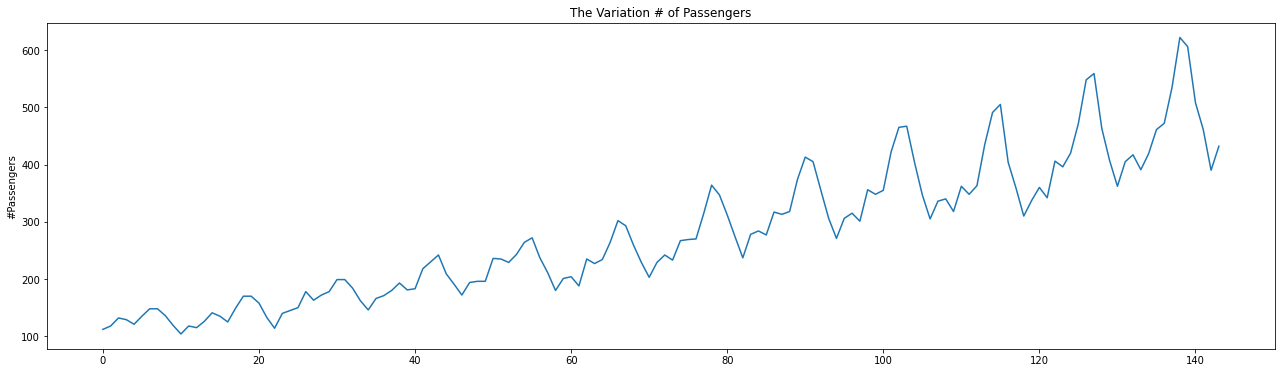

In [37]:
plt.figure(figsize=(22,6))
sns.lineplot(x=df.index, y=df['#Passengers'])
plt.title('The Variation # of Passengers')
plt.show()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [46]:
df[['year','month']] = df['Month'].str.split('-', expand=True)
df['Month'] = df[['year','month']].apply('-'.join, axis=1)


In [47]:
df

,Month,#Passengers,year,month
0,1949-01,112,1949,01
1,1949-02,118,1949,02
2,1949-03,132,1949,03
3,1949-04,129,1949,04
4,1949-05,121,1949,05
...,...,...,...,...
139,1960-08,606,1960,08
140,1960-09,508,1960,09
141,1960-10,461,1960,10
142,1960-11,390,1960,11


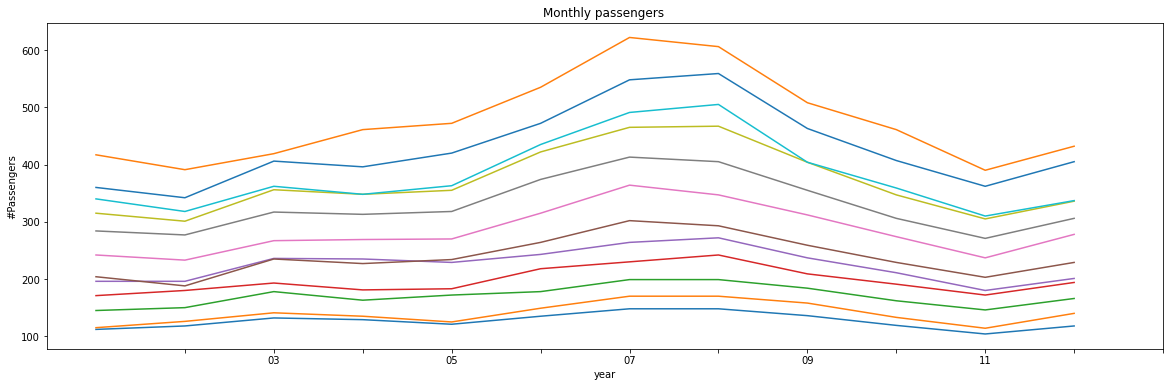

In [64]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
df['month'] = df.month
df['year'] = df.year
pivot = pd.pivot_table(df, values='#Passengers', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Monthly passengers ')
plt.xlabel('year')
plt.ylabel('#Passengers')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

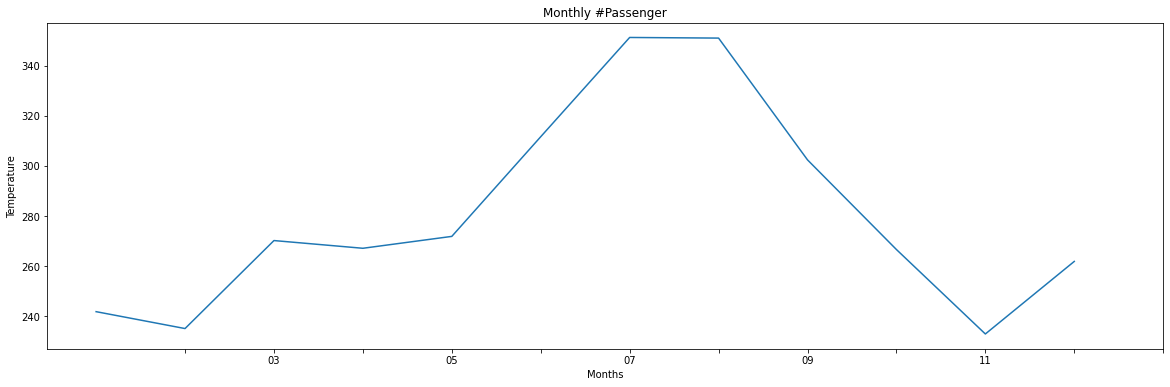

In [65]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly #Passenger')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

In [113]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [62]:
df

,#Passengers,year,month
Month,,,
1949-01,112,1949,01
1949-02,118,1949,02
1949-03,132,1949,03
1949-04,129,1949,04
1949-05,121,1949,05
...,...,...,...
1960-08,606,1960,08
1960-09,508,1960,09
1960-10,461,1960,10


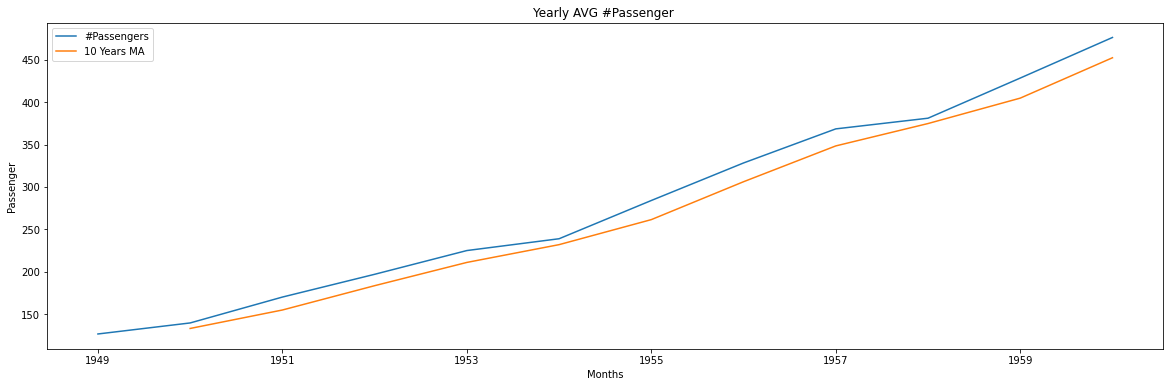

In [75]:

year_avg = pd.pivot_table(df, values='#Passengers', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['#Passengers'].rolling(2).mean()
#print(year_avg)
year_avg[['#Passengers','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG #Passenger ')
plt.xlabel('Months')
plt.ylabel('Passenger')
plt.show()

In [83]:
#Determine rolling statistics
#df.set_index('Month', inplace=True)
rolmean = df[["#Passengers"]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df[["#Passengers"]].rolling(window=12).std()
#print(rolmean,rolstd)

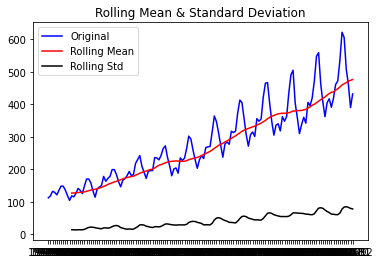

In [88]:
#Plot rolling statistics
orig = plt.plot(df[["#Passengers"]], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [92]:
train = df.reset_index(drop=True)[:-60].copy()
val = df.reset_index(drop=True)[-60:-12].copy()
test = df.reset_index(drop=True)[-12:].copy()

In [101]:
import statsmodels.api as sm

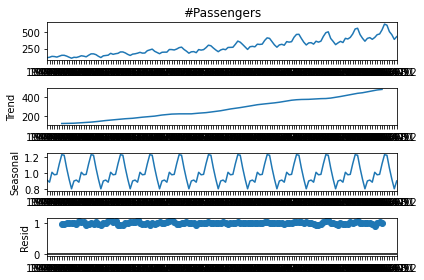

The data has trend in the negative


In [107]:
dec = sm.tsa.seasonal_decompose(df['#Passengers'],period = 12, model = 'multiplicative')
fig = dec.plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)
plt.show()
print("The data has trend in the negative")

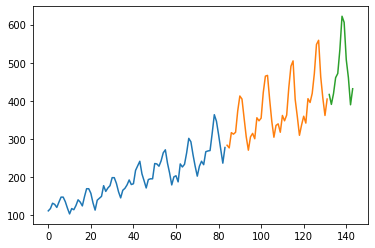

In [94]:
# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
train["#Passengers"].plot(ax=ax)
val["#Passengers"].plot(ax=ax)
test["#Passengers"].plot(ax=ax)
plt.show()

In [109]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [111]:
import statsmodels.tsa.api as smt

In [112]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

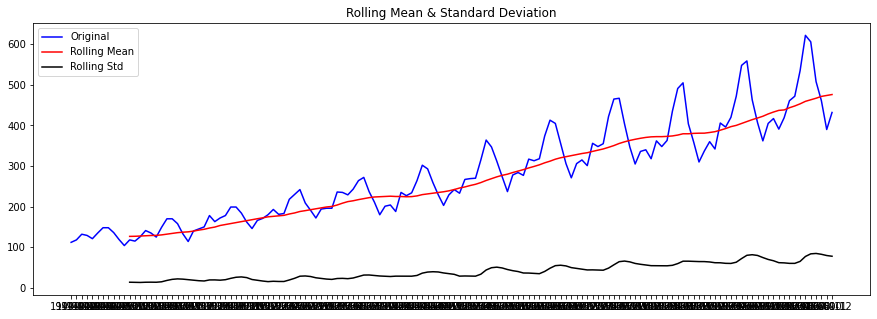

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [114]:
test_stationarity(df['#Passengers'])